## P02: Cleaning the images, and making them to the appropriate shape for model

Importing the required libraries:

In [1]:
#Source: https://www.kaggle.com/lezwon/xview2-challenge
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

from pathlib import Path
import json
from random import randint
from collections import Counter
from collections import defaultdict
import rasterio

import json 
from PIL import Image, ImageDraw
from IPython.display import display
from shapely import wkt
from shapely.geometry.multipolygon import MultiPolygon

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
from copy import copy 

%matplotlib inline
# figure size in inches optional
rcParams['figure.figsize'] = 30, 30
plt.rcParams['legend.title_fontsize'] = 14

First, I am inserting the post-fire training satellite images

In [2]:
# Fetch all post disaster json files
labels_generator = Path('../datasets/train/labels').rglob(pattern=f'*post_*.json')

disaster_dict = defaultdict(list)
for label in labels_generator:
    disaster_type = label.name.split('_')[0]
    disaster_dict[disaster_type].append(str(label))
disaster_dict.keys()

dict_keys(['santa-rosa-wildfire'])

In [3]:
disaster_dict['santa-rosa-wildfire']

['../datasets/train/labels/santa-rosa-wildfire_00000015_post_disaster.json',
 '../datasets/train/labels/.ipynb_checkpoints/santa-rosa-wildfire_00000015_post_disaster-checkpoint.json']

In [4]:
# Select a particular disaster
disaster_labels = disaster_dict['santa-rosa-wildfire']

Putting a color-code with respect to the damage style

In [7]:
# Color codes for polygons
damage_dict = {
    "no-damage": (0, 255, 0, 50),
    "minor-damage": (0, 0, 255, 50),
    "major-damage": (255, 69, 0, 50),
    "destroyed": (255, 0, 0, 50),
    "un-classified": (255, 255, 255, 50)
}

In [8]:
def get_damage_type(properties):
    if 'subtype' in properties:
        return properties['subtype']
    else:
        return 'no-damage'

In [9]:
def annotate_img(draw, coords):
        wkt_polygons = []

        for coord in coords:
            damage = get_damage_type(coord['properties'])
            wkt_polygons.append((damage, coord['wkt']))

        polygons = []

        for damage, swkt in wkt_polygons:
            polygons.append((damage, wkt.loads(swkt)))

        for damage, polygon in polygons:
            x,y = polygon.exterior.coords.xy
            coords = list(zip(x,y))
            draw.polygon(coords, damage_dict[damage])

        del draw

In [10]:
def display_img(json_path, time='post', annotated=True):
    if time=='pre':
        json_path = json_path.replace('post', 'pre')
        
    img_path = json_path.replace('labels', 'images').replace('json','png')
    
    with open(json_path) as json_file:
        image_json = json.load(json_file)
    
#    image_json = read_label(json_path)
    img_name = image_json['metadata']['img_name']
        
    print(img_name)
    
    img = Image.open(img_path)
    draw = ImageDraw.Draw(img, 'RGBA')
    
    if annotated:
        annotate_img(draw, image_json['features']['xy'])

    return img

In [11]:
disaster_labels[0]

'../datasets/train/labels/santa-rosa-wildfire_00000015_post_disaster.json'

santa-rosa-wildfire_00000015_post_disaster.png


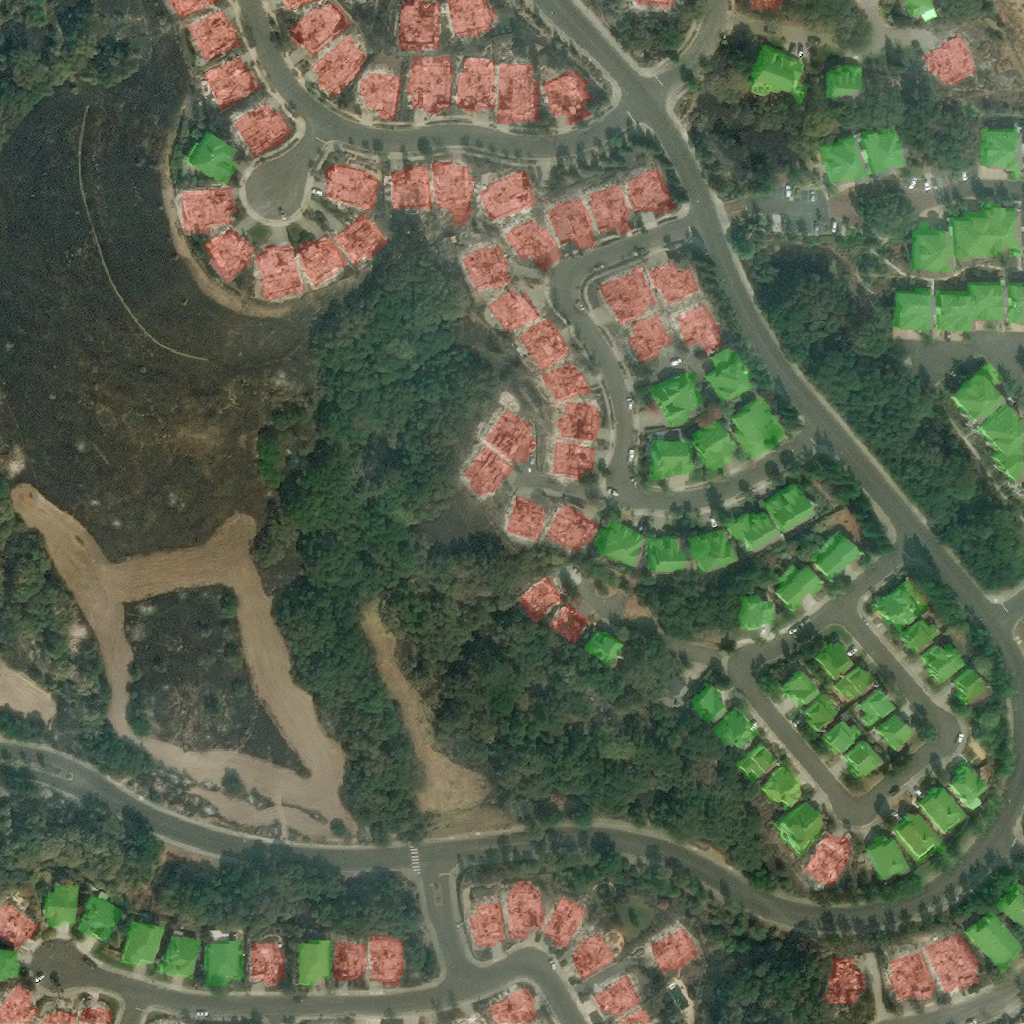

In [24]:
#Source: https://www.kaggle.com/lezwon/xview2-challenge


# Display a single image using label path. 
# `time` argument shows post or pre disaster images
# `annotated` argument labels images
img = display_img(disaster_labels[0], time='post', annotated=True)

#plt.figure(figsize=(20, 10))

img

#plt.savefig("../plots/a_medium_fig01.png")

This image shows the satellite images overlaid by polygons

### Now, using the polygons dataframe, just chipping the images and saving them.

In [13]:
wkt_polygons = []
json_path = "../datasets/train/labels/santa-rosa-wildfire_00000015_post_disaster.json"
with open(json_path) as json_file:
        image_json = json.load(json_file)

coords = image_json['features']['xy']

for coord in coords:
    damage = get_damage_type(coord['properties'])
    wkt_polygons.append((damage, coord['wkt']))

polygons = []
polygon_coords = []

for damage, swkt in wkt_polygons:
    polygons.append((damage, wkt.loads(swkt)))
    polygon_coords.append((wkt.loads(swkt)))

cnt = -1    
polygon_list = []
damage_list = []
mask_number = []
for damage, polygon in polygons:
    cnt+=1
    x,y = polygon.exterior.coords.xy
    polygon_list.append(list(zip(x,y)))
    damage_list.append(damage)
    mask_number.append(cnt)
    #print(polygon)

masks_df = pd.DataFrame({"mask_number": mask_number, "polygon_xy_coords": polygon_list, "damage_type": damage_list})

In [14]:
masks_df.head()

,mask_number,polygon_xy_coords,damage_type
0,0,"[(221.4355524114044, 0.005081457035730892), (1...",destroyed
1,1,"[(319.5733219028502, 0.006400528588852944), (2...",destroyed
2,2,"[(330.5176007079036, 3.631724476424699), (331....",destroyed
3,3,"[(348.8109931184065, 36.20288657400091), (367....",destroyed
4,4,"[(366.5014604720032, 79.80206247816938), (367....",destroyed


In [15]:
masks_df["damage_type"].value_counts(normalize = True)

destroyed    0.528455
no-damage    0.471545
Name: damage_type, dtype: float64

In [16]:
#Source: https://stackoverflow.com/questions/22588074/polygon-crop-clip-using-python-pil
import numpy
from PIL import Image, ImageDraw

# read image as RGB and add alpha (transparency)
im = Image.open("../datasets/train/images/santa-rosa-wildfire_00000015_post_disaster.png").convert("RGBA")
# convert to numpy (for convenience)
imArray = numpy.asarray(im)

for ind, polygon in enumerate(masks_df["polygon_xy_coords"]):
    
    # create mask
    maskIm = Image.new('L', (imArray.shape[1], imArray.shape[0]), 0)
    ImageDraw.Draw(maskIm).polygon(polygon, outline=1, fill=1)
    mask = numpy.array(maskIm)

    # assemble new image (uint8: 0-255)
    newImArray = numpy.empty(imArray.shape,dtype='uint8')
    # colors (three first columns, RGB)
    newImArray[:,:,:3] = imArray[:,:,:3]
    # transparency (4th column)
    newImArray[:,:,3] = mask*255
    # back to Image from numpy
    newIm = Image.fromarray(newImArray, "RGBA")
    newIm.save(f"../datasets/train/masks/santa-rosa-wildfire_00000015_post_disaster_out{ind}.png")
    

## Crop images

In [18]:
H = masks_df["polygon_xy_coords"][0]
H

[(221.4355524114044, 0.005081457035730892),
 (180.8908608413462, 18.37630201855297),
 (169.1583952388306, 0.004159507599657722),
 (221.4355524114044, 0.005081457035730892)]

Checking the cropped images shape

In [19]:
import cv2

im = cv2.imread('../datasets/train/masks/santa-rosa-wildfire_00000015_post_disaster_out0.png')

print(type(im))
# <class 'numpy.ndarray'>

print(im.shape)
print(type(im.shape))

<class 'numpy.ndarray'>
(1024, 1024, 3)
<class 'tuple'>


In [20]:
# for j in range(len(masks_df["polygon_xy_coords"])):
    
#     Xs = []
#     Ys = []
#     for i in range(len(masks_df["polygon_xy_coords"][j])):
#         Xs.append(masks_df["polygon_xy_coords"][j][i][0])
#         Ys.append(masks_df["polygon_xy_coords"][j][i][1])

#     corners = (min(Xs), min(Ys), max(Xs), max(Ys))

#     im = Image.open(f'../datasets/train/masks/santa-rosa-wildfire_00000015_post_disaster_out{j}.png')


#     im_crop = im.crop(corners)
#     im_crop.save(f'../datasets/train/masks_cropped/santa-rosa-wildfire_00000015_post_disaster_out{j}_cropped.png')
# #im_crop.show

## Let's make a variation where different labels are put into two different folders

In [21]:
for j in range(len(masks_df["polygon_xy_coords"])):
    
    Xs = []
    Ys = []
    for i in range(len(masks_df["polygon_xy_coords"][j])):
        Xs.append(masks_df["polygon_xy_coords"][j][i][0])
        Ys.append(masks_df["polygon_xy_coords"][j][i][1])

    corners = (min(Xs), min(Ys), max(Xs), max(Ys))

    im = Image.open(f'../datasets/train/masks/santa-rosa-wildfire_00000015_post_disaster_out{j}.png')


    im_crop = im.crop(corners)
    if (masks_df["damage_type"][j] == "no-damage"):
        im_crop.save(f'../datasets/train/labeled_ready/masks_no_damage_lbl/santa-rosa-wildfire_00000015_post_disaster_out{j}_cropped.png')
    elif (masks_df["damage_type"][j] == "destroyed"):
        im_crop.save(f'../datasets/train/labeled_ready/masks_destroyed_lbl/santa-rosa-wildfire_00000015_post_disaster_out{j}_cropped.png')
#im_crop.show

In [22]:
import cv2

im = cv2.imread('../datasets/train/masks_cropped/santa-rosa-wildfire_00000015_post_disaster_out0_cropped.png')

print(type(im))
# <class 'numpy.ndarray'>

print(im.shape)
print(type(im.shape))

<class 'numpy.ndarray'>
(18, 52, 3)
<class 'tuple'>


In [23]:
print("Hello World!")

Hello World!
